In [1]:
import os
import sys
import numpy as np
import time
import warnings
import random
import matplotlib.pyplot as plt




# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

    
from multi_dimension.Multidimension_trees import *
from multi_dimension.Multidimension_solver import *
from multi_dimension.Multidimension_adapted_empirical_measure import *

from measure_sampling.Gen_Path_and_AdaptedTrees import generate_adapted_tree
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *
from trees.Build_trees_from_paths import build_tree_from_paths

from adapted_empirical_measure.AEM_grid import *
from adapted_empirical_measure.AEM_kMeans import *
from benchmark_value_gaussian.Comp_AWD2_Gaussian import *
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance, compute_nested_distance_parallel, compute_nested_distance_parallel_generic

from utils_solver import Lmatrix2paths, adapted_empirical_measure, adapted_wasserstein_squared, quantization, nested, plot_V

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

KeyboardInterrupt: 

## Sampling function: sample paths for measure "mu" and "nu"

In [47]:
def My_Lmatrix2paths(L, n_sample, normalize=False, seed=0):
    r"""
    Lower triangular matrix L to covariance matrix A and generated paths
    """
    A0 = L @ L.T  # A = LL^T
    L = L / np.sqrt(np.trace(A0)) if normalize else L
    A = L @ L.T

    T = len(L)

    np.random.seed(seed)
    noise1 = np.random.normal(size=[T, n_sample])  # (T, n_sample)
    X = L @ noise1  # (T, n_sample)
    X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)  # (T+1, n_sample)
    return X, A

def sample_paths(L, M, n_sample, same_seed=True):
    """
    Sample paths for measures mu and nu using Lmatrix2paths.
    If same_seed is True then both measures use the same random seed;
    otherwise a different seed is generated for each.
    """
    seed_mu = np.random.randint(0, 10000)
    seed_nu = seed_mu if same_seed else np.random.randint(0, 10000)
    X, A = My_Lmatrix2paths(L, n_sample, seed=seed_mu)
    Y, B = My_Lmatrix2paths(M, n_sample, seed=seed_nu)
    return X.T, Y.T

## Utilites functions

In [48]:
def run_experiment(measure_func, sample_sizes, n_runs, L, M, same_seed=True, num_chunks = 6):
    """
    Runs the experiment for each sample size and run.
    
    Parameters:
      measure_func: function to adapt the empirical measure (e.g., uniform_empirical_grid_measure)
      sample_sizes: list of sample sizes to test
      n_runs: number of runs per sample size
      L, M: matrices for measures mu and nu
      dim: effective dimension (used later for grid size computation)
      same_seed: if True, use the same seed for both measures in each run
      
    Returns:
      distances_all: 2D array of computed nested distances
      times_all: 2D array of computation times
    """
    distances_all = np.zeros((len(sample_sizes), n_runs))
    times_all = np.zeros((len(sample_sizes), n_runs))
    
    for i, n_sample in enumerate(sample_sizes):
        for run_idx in range(n_runs):
            print(f"Sample Size: {n_sample}, Run {run_idx+1}/{n_runs}")
            # Sample paths (new random seeds each run)
            X, Y = sample_paths(L, M, n_sample, same_seed)
            # Adapt the empirical measure (using the provided measure function)
            adapted_X, adapted_weights_X = measure_func(X, delta_n = 0.1, use_weights=True)
            adapted_Y, adapted_weights_Y = measure_func(Y, delta_n = 0.1, use_weights=True)
            # Build trees from the adapted paths
            tree_1 = build_tree_from_paths(adapted_X, adapted_weights_X)
            tree_2 = build_tree_from_paths(adapted_Y, adapted_weights_Y)
            # Compute nested distance and record timing
            max_depth = get_depth(tree_1)
            start_time = time.time()
            distance_pot = compute_nested_distance_parallel(
                tree_1, tree_2, max_depth, power=2, num_chunks=num_chunks
            )
            elapsed_time = time.time() - start_time
            distances_all[i, run_idx] = distance_pot
            times_all[i, run_idx] = elapsed_time
            
    return distances_all, times_all

def plot_results(sample_sizes, distances_all, times_all, distance_benchmark, method, t):
    """
    Plots:
      - Mean distance (with ±std band) vs sample size (with a horizontal benchmark line)
      - Mean computation time (with ±std band)
      - Absolute error (benchmark minus computed mean); if method=='uniform_grid', also plots grid size.
    """
    distances_mean = distances_all.mean(axis=1)
    distances_std = distances_all.std(axis=1)
    times_mean = times_all.mean(axis=1)
    times_std = times_all.std(axis=1)
    
    # Plot 1: Distance Convergence
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, distances_mean, marker="o", label="Mean Distance")
    plt.fill_between(sample_sizes, distances_mean - distances_std, distances_mean + distances_std, 
                     alpha=0.2, label="Std Dev")
    plt.axhline(y=distance_benchmark, color="red", linestyle="--", label="Benchmark")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Adapted Wasserstein Distance")
    plt.title(f"Distance Convergence - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 2: Computation Time
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, times_mean, marker="o", label="Mean Computation Time")
    plt.fill_between(sample_sizes, times_mean - times_std, times_mean + times_std,
                     alpha=0.2, label="Std Dev")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Computation Time (s)")
    plt.title(f"Computation Time - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 3: Absolute Error vs Grid Size (if method is uniform_grid)
    error_mean = np.abs(distance_benchmark - distances_mean)
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, error_mean, marker='o', label='Absolute Error')
    if method == "uniform_grid":
        grid_sizes = np.array([1 / (n ** (1/t+1)) for n in sample_sizes])
        plt.plot(sample_sizes, grid_sizes, marker='s', label='Grid Size (delta_n)')
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Value")
    plt.title(f"Absolute Error - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [50]:
# Experiment parameters
n_runs = 2
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [2, 4, 0],
                       [3, 2, 1]])
M_sampling = np.array([[1, 0, 0],
                       [2, 3, 0],
                       [3, 1, 2]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [10000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=True, num_chunks = 12)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

Benchmark distance: 3.0
Sample Size: 10000, Run 1/2
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

Benchmark distance: 10.0
Sample Size: 200, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 500, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0


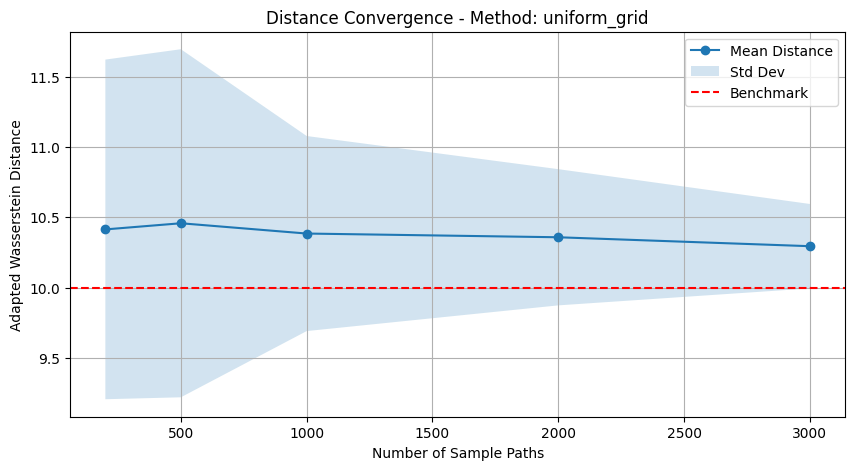

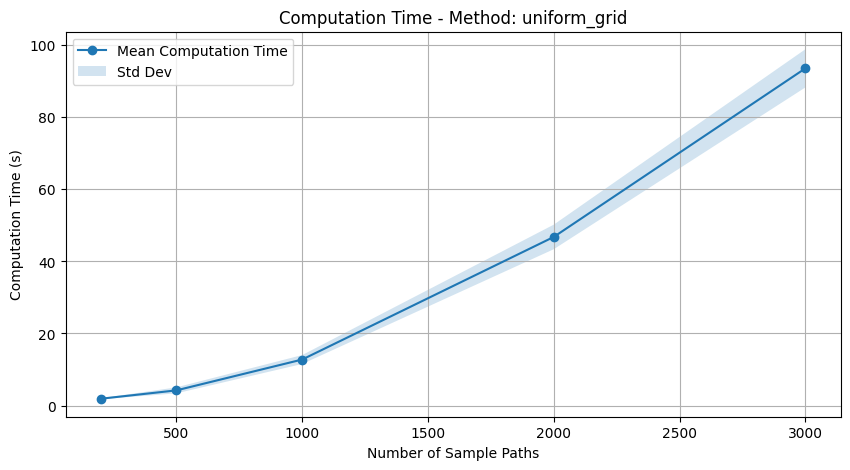

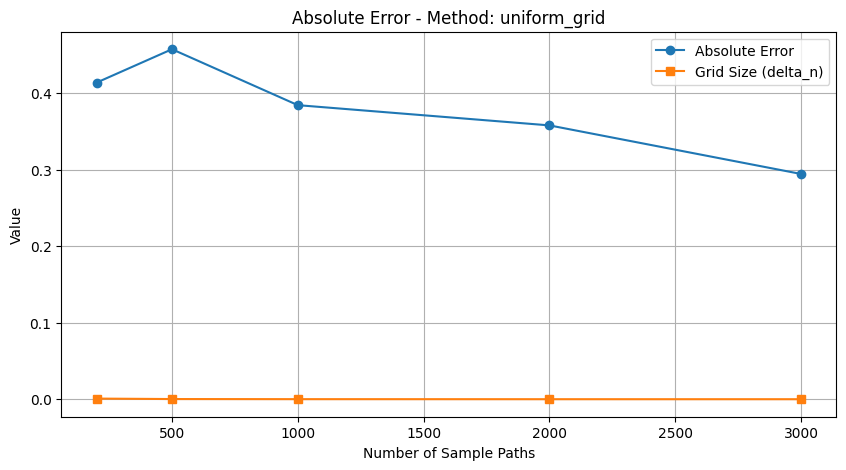

In [39]:
# Experiment parameters
n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [1, 2, 0],
                       [1, 2, 3]])
M_sampling = np.array([[1, 0, 0],
                       [2, 1, 0],
                       [3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 3000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 6)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)


Benchmark distance: 10.0
Sample Size: 200, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sa

Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 10/10
Depth: 2
Depth: 1
Depth: 0


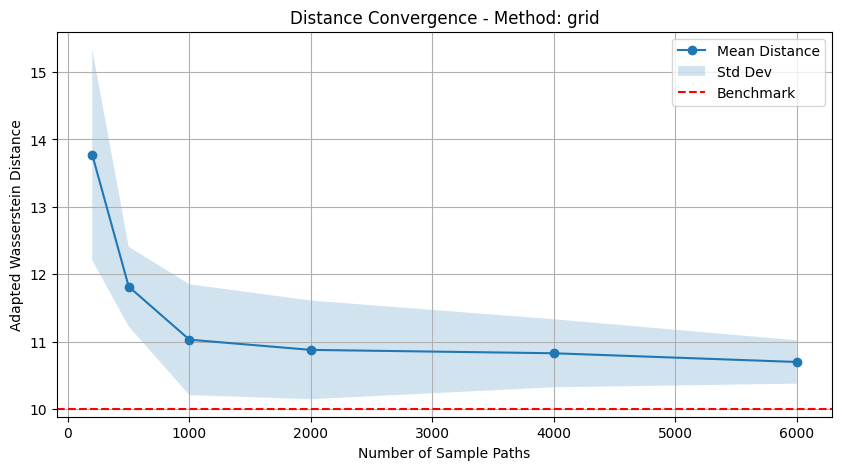

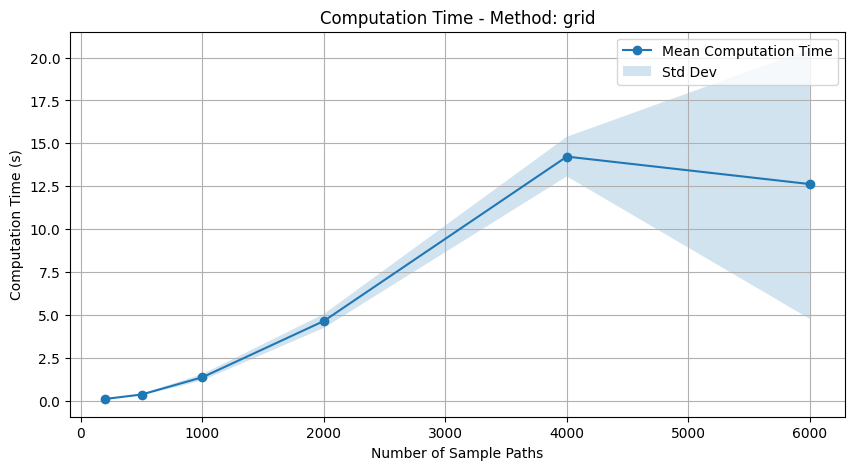

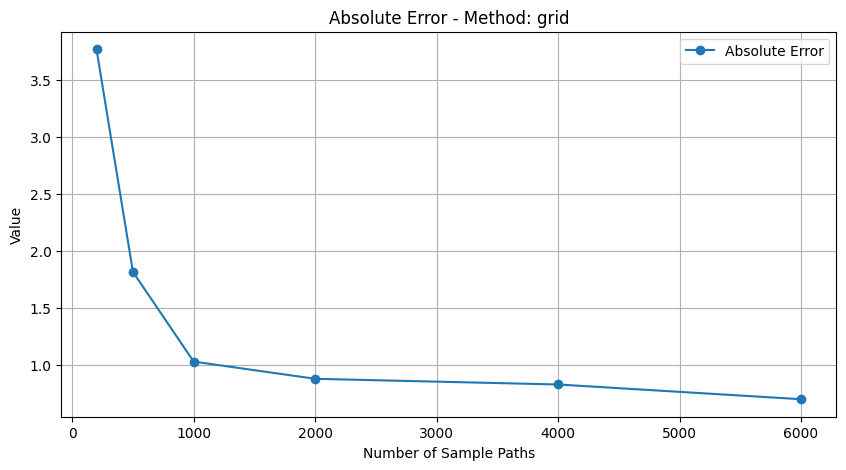

In [22]:
# Experiment parameters
n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [1, 2, 0],
                       [1, 2, 3]])
M_sampling = np.array([[1, 0, 0],
                       [2, 1, 0],
                       [3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 4000, 6000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 12)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

Benchmark distance: 10.0
Sample Size: 200, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sa

Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 2000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 1/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 2/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 3/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 4/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 5/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 6/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 7/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 8/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 9/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 6000, Run 10/10
Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0


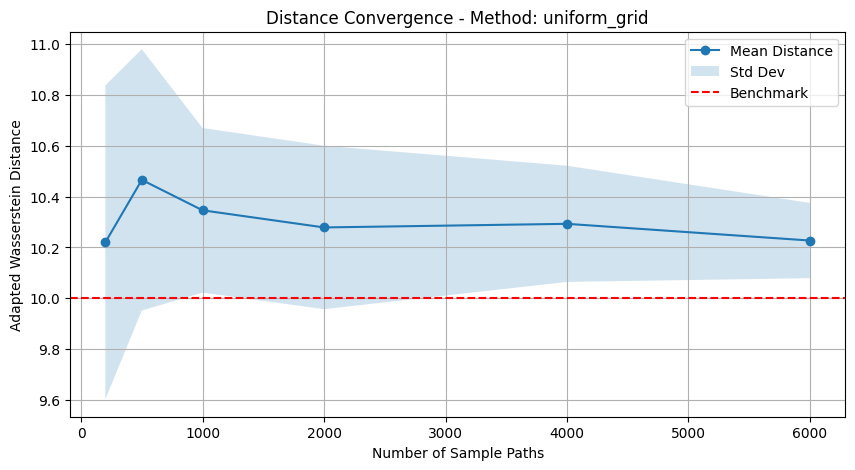

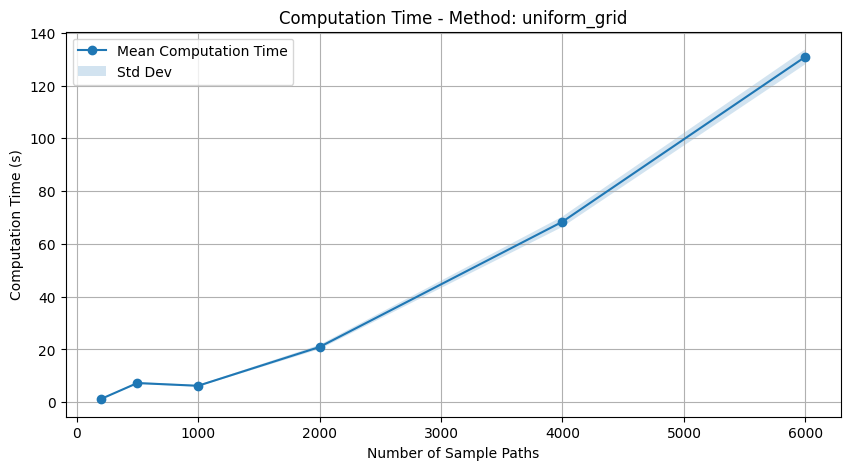

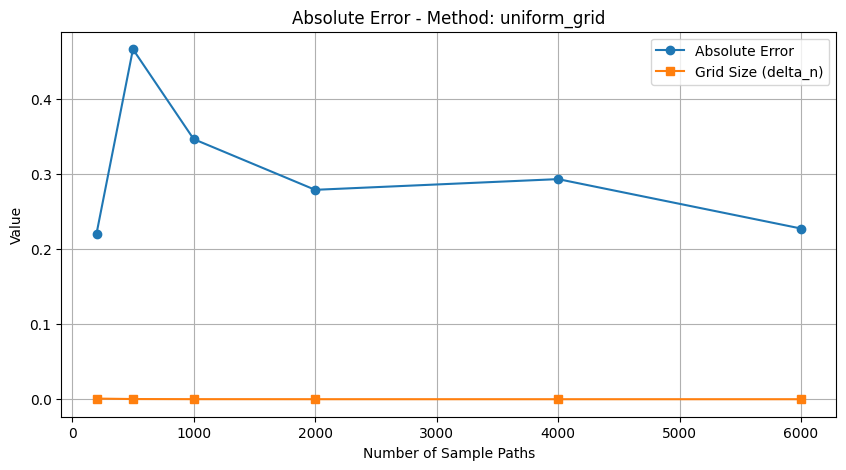

In [24]:
# Experiment parameters
n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [1, 2, 0],
                       [1, 2, 3]])
M_sampling = np.array([[1, 0, 0],
                       [2, 1, 0],
                       [3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 4000, 6000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=True, num_chunks = 12)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

Benchmark distance: 10.0
Sample Size: 200, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 6/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 7/10
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 8/10
Depth: 2
Depth: 1
Depth: 0
Sa

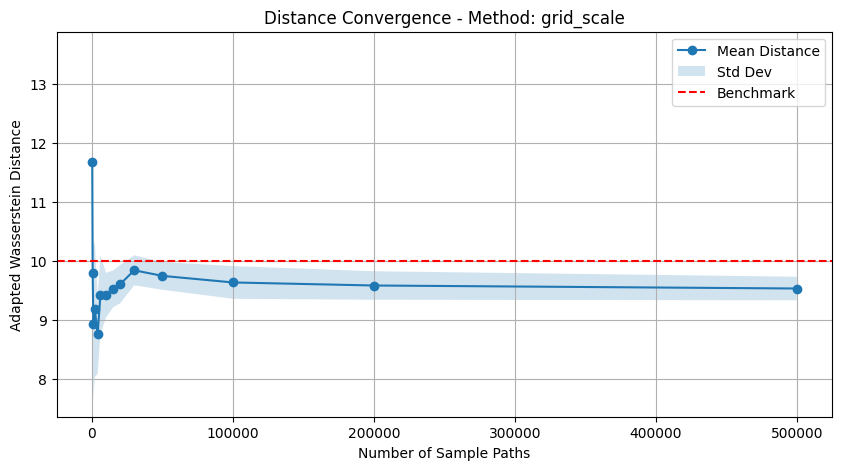

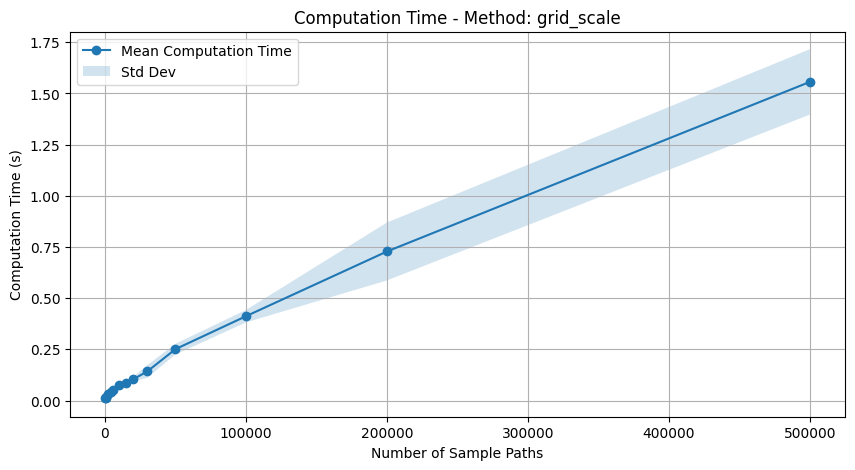

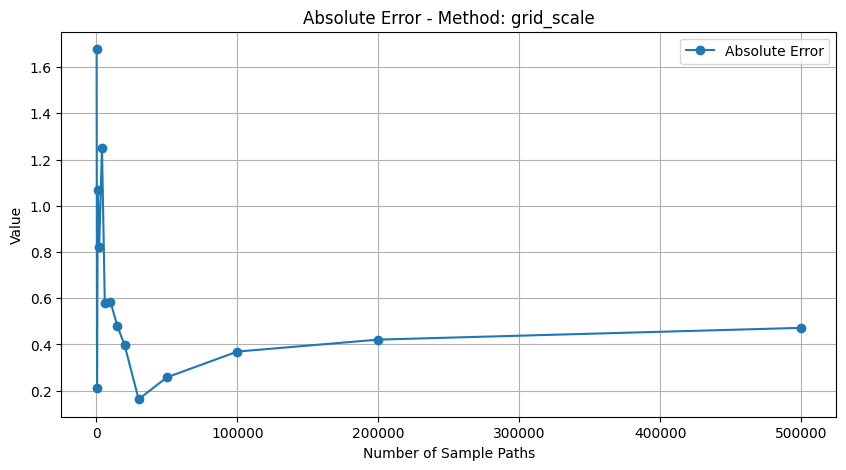

In [10]:
# Experiment parameters
n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [1, 2, 0],
                       [1, 2, 3]])
M_sampling = np.array([[1, 0, 0],
                       [2, 1, 0],
                       [3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 4000, 6000, 10000, 15000, 20000, 30000, 50000, 100000, 200000, 500000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new", "grid_scale"
measure_method = "grid_scale"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
elif measure_method == "grid_scale":
    measure_func =uniform_empirical_grid_measure_spread
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 12)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

In [ ]:
# Experiment parameters
n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0],
                       [1, 2, 0],
                       [1, 2, 3]])
M_sampling = np.array([[1, 0, 0],
                       [2, 1, 0],
                       [3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 4000, 6000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 6)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

Benchmark distance: 30.0
Sample Size: 200, Run 1/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1000, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 1500, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 3000, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4500, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/6 [00:00<?, ?it/s]

Depth: 1
Depth: 0


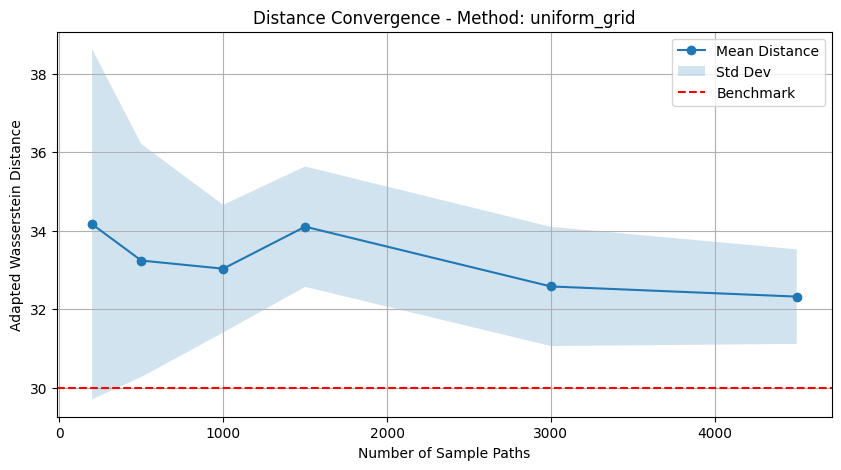

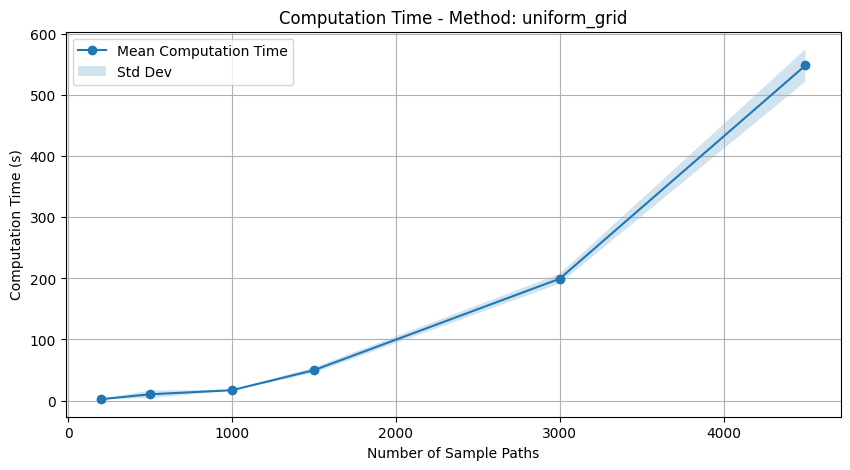

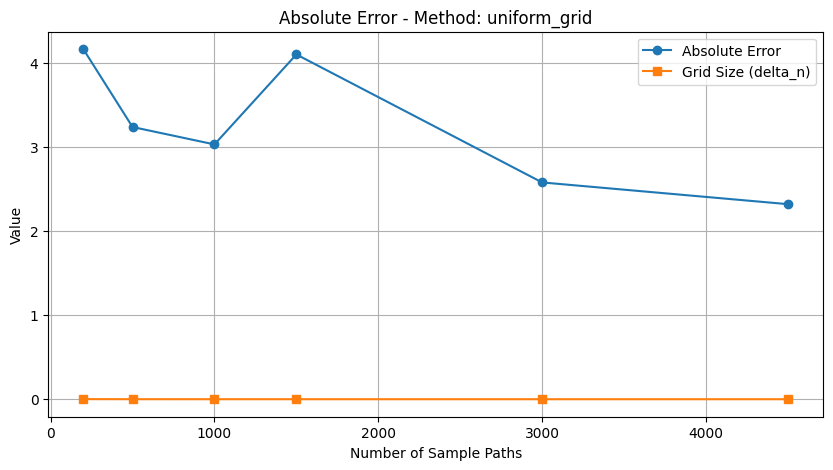

In [16]:
# Experiment parameters


n_runs = 10
# Matrices for sampling points (as in your initial code for "mu" and "nu")
L_sampling = np.array([[1, 0, 0, 0], [1, 2, 0, 0], [1, 2, 3, 0], [1,2,3, 4]])
M_sampling = np.array([[1, 0, 0, 0], [2, 1, 0, 0], [3, 2, 1, 0], [4, 3, 2, 1]])
dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 1500, 3000, 4500]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 6)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)


In [21]:
# Experiment parameters
n_runs = 10

L_sampling = np.array([[1, 0, 0, 0,],
 [0.33333333, 0.66666667, 0, 0],
 [0.14285714, 0.28571429, 0.57142857, 0],
 [0.06666667, 0.13333333, 0.26666667, 0.53333333]])

M_sampling = np.array([[1, 0, 0, 0],
 [0.44444444, 0.55555556, 0, 0],
 [0.26229508, 0.32786885, 0.40983607, 0],
 [0.17344173, 0.21680217, 0.27100271, 0.33875339]])

dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 500, 1000, 2000, 4000]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 12)

Benchmark distance: 0.12309403700958566
Sample Size: 200, Run 1/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 2/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 3/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 4/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 5/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 6/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 7/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 8/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 9/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 200, Run 10/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 1/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 2/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 3/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 4/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 500, Run 5/10
Depth: 3
Depth: 2
Depth: 1
Depth: 0
Sample Size: 5

Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 1000, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 2000, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2
Depth: 1
Depth: 0
Sample Size: 4000, Run 1/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 2/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 3/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 4/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 5/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 6/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 7/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 8/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 9/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0
Sample Size: 4000, Run 10/10
Depth: 3


Parallel Depth 3:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 2


Parallel Depth 2:   0%|          | 0/12 [00:00<?, ?it/s]

Depth: 1
Depth: 0


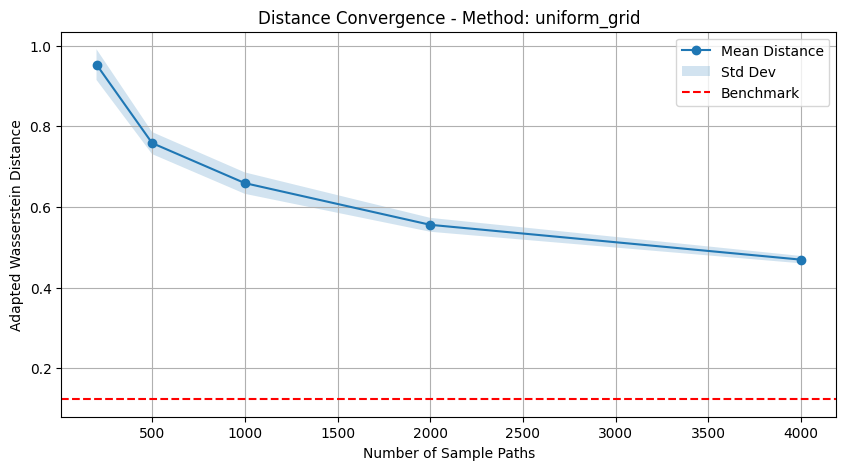

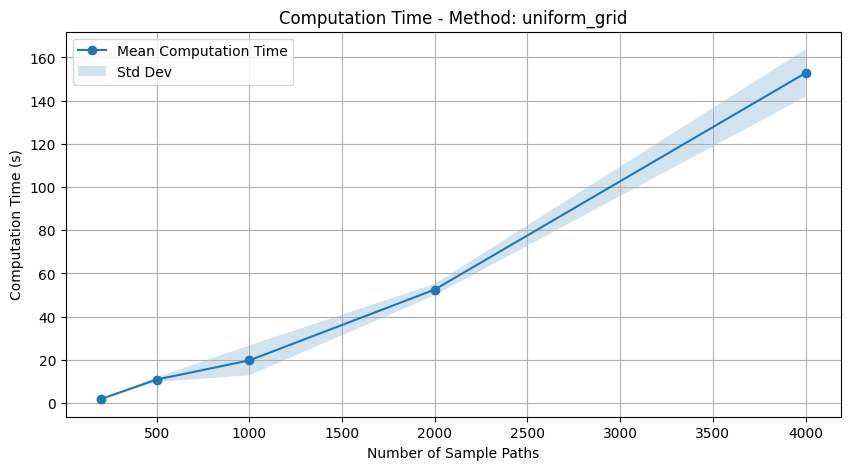

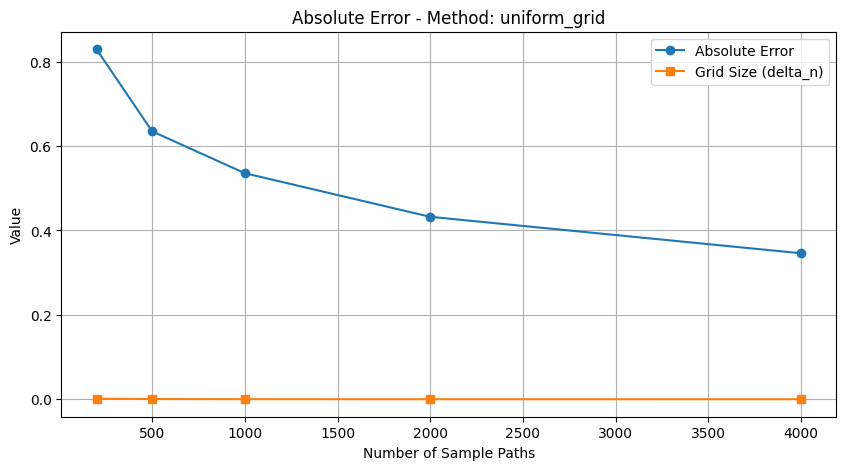

In [22]:
# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

# Markov

In [34]:
def run_experiment(measure_func, sample_sizes, n_runs, L, M, same_seed=True, num_chunks = 6):
    """
    Runs the experiment for each sample size and run.
    
    Parameters:
      measure_func: function to adapt the empirical measure (e.g., uniform_empirical_grid_measure)
      sample_sizes: list of sample sizes to test
      n_runs: number of runs per sample size
      L, M: matrices for measures mu and nu
      dim: effective dimension (used later for grid size computation)
      same_seed: if True, use the same seed for both measures in each run
      
    Returns:
      distances_all: 2D array of computed nested distances
      times_all: 2D array of computation times
    """
    distances_all = np.zeros((len(sample_sizes), n_runs))
    times_all = np.zeros((len(sample_sizes), n_runs))
    
    for i, n_sample in enumerate(sample_sizes):
        for run_idx in range(n_runs):
            print(f"Sample Size: {n_sample}, Run {run_idx+1}/{n_runs}")
            # Sample paths (new random seeds each run)
            X, Y = sample_paths(L, M, n_sample, same_seed)
            # Adapt the empirical measure (using the provided measure function)
            adapted_X = adapted_empirical_measure(X.T, delta_n = 5 / (n_sample ** (1/4+1)))
            adapted_Y = adapted_empirical_measure(Y.T, delta_n = 5 / (n_sample ** (1/4+1)))
            # Build trees from the adapted paths
            q2v, v2q, mu_x, nu_y, q2v_x, v2q_x, q2v_y, v2q_y = quantization(adapted_X, adapted_Y, markovian=True)

            start_time = time.time()
            distance_pot = compute_nested_distance_parallel_generic(mu_x, nu_y, v2q_x, v2q_y, q2v, markovian=True, num_chunks=12)
            elapsed_time = time.time() - start_time
            distances_all[i, run_idx] = distance_pot
            times_all[i, run_idx] = elapsed_time
            
    return distances_all, times_all

def plot_results(sample_sizes, distances_all, times_all, distance_benchmark, method, t):
    """
    Plots:
      - Mean distance (with ±std band) vs sample size (with a horizontal benchmark line)
      - Mean computation time (with ±std band)
      - Absolute error (benchmark minus computed mean); if method=='uniform_grid', also plots grid size.
    """
    distances_mean = distances_all.mean(axis=1)
    distances_std = distances_all.std(axis=1)
    times_mean = times_all.mean(axis=1)
    times_std = times_all.std(axis=1)
    
    # Plot 1: Distance Convergence
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, distances_mean, marker="o", label="Mean Distance")
    plt.fill_between(sample_sizes, distances_mean - distances_std, distances_mean + distances_std, 
                     alpha=0.2, label="Std Dev")
    plt.axhline(y=distance_benchmark, color="red", linestyle="--", label="Benchmark")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Adapted Wasserstein Distance")
    plt.title(f"Distance Convergence - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 2: Computation Time
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, times_mean, marker="o", label="Mean Computation Time")
    plt.fill_between(sample_sizes, times_mean - times_std, times_mean + times_std,
                     alpha=0.2, label="Std Dev")
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Computation Time (s)")
    plt.title(f"Computation Time - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 3: Absolute Error vs Grid Size (if method is uniform_grid)
    error_mean = np.abs(distance_benchmark - distances_mean)
    plt.figure(figsize=(10, 5))
    plt.plot(sample_sizes, error_mean, marker='o', label='Absolute Error')
    if method == "uniform_grid":
        grid_sizes = np.array([1 / (n ** (1/t+1)) for n in sample_sizes])
        plt.plot(sample_sizes, grid_sizes, marker='s', label='Grid Size (delta_n)')
    plt.xlabel("Number of Sample Paths")
    plt.ylabel("Value")
    plt.title(f"Absolute Error - Method: {method}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Experiment parameters
n_runs = 10

L_sampling = np.array([[1, 0, 0, 0,],
 [0.33333333, 0.66666667, 0, 0],
 [0.14285714, 0.28571429, 0.57142857, 0],
 [0.06666667, 0.13333333, 0.26666667, 0.53333333]])

M_sampling = np.array([[1, 0, 0, 0],
 [0.44444444, 0.55555556, 0, 0],
 [0.26229508, 0.32786885, 0.40983607, 0],
 [0.17344173, 0.21680217, 0.27100271, 0.33875339]])

dim = L_sampling.shape[0]
# Choose sample sizes (you can adjust this list as needed)
sample_sizes = [200, 300, 500, 700]

# Compute a benchmark distance.
# Here we simply compute A = L_sampling @ L_sampling.T and B = M_sampling @ M_sampling.T for the benchmark.
A_sampling = L_sampling @ L_sampling.T
B_sampling = M_sampling @ M_sampling.T
distance_benchmark = adapted_wasserstein_squared_1d(np.zeros((dim,)), A_sampling, np.zeros((dim,)), B_sampling)
print("Benchmark distance:", distance_benchmark)

# Select the empirical measure method.
# Options: "uniform_grid", "grid", "kmeans", "kmeans_new"
measure_method = "uniform_grid"


if measure_method == "uniform_grid":
    measure_func = uniform_empirical_grid_measure
elif measure_method == "grid":
    measure_func = empirical_grid_measure
elif measure_method == "kmeans_new":
    measure_func = empirical_k_means_measure_new
else:
    raise ValueError("Unknown measure method.")

# Run the experiment (set same_seed=True if you want both measures to use the same seed)
distances_all, times_all = run_experiment(measure_func, sample_sizes, n_runs, L_sampling, M_sampling, same_seed=False, num_chunks = 12)

# Plot the results (t is the effective time-step used in grid size computation; here we use dim)
plot_results(sample_sizes, distances_all, times_all, distance_benchmark, measure_method, t=dim)

Benchmark distance: 0.12309403700958566
Sample Size: 200, Run 1/10
Quantization ......
Number of distinct values in global quantization:  457
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 164
Time 2: 155
Time 3: 150
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 161
Time 2: 165
Time 3: 142
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 2/10
Quantization ......
Number of distinct values in global quantization:  473
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 164
Time 2: 150
Time 3: 149
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 168
Time 2: 162
Time 3: 146
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 3/10
Quantization ......
Number of distinct values in global quantization:  454
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 173
Time 2: 159
Time 3: 153
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 167
Time 2: 155
Time 3: 150
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 4/10
Quantization ......
Number of distinct values in global quantization:  455
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 169
Time 2: 156
Time 3: 148
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 167
Time 2: 150
Time 3: 148
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 5/10
Quantization ......
Number of distinct values in global quantization:  474
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 168
Time 2: 159
Time 3: 150
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 173
Time 2: 143
Time 3: 144
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 6/10
Quantization ......
Number of distinct values in global quantization:  463
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 169
Time 2: 159
Time 3: 158
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 167
Time 2: 158
Time 3: 145
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 7/10
Quantization ......
Number of distinct values in global quantization:  480
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 164
Time 2: 163
Time 3: 155
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 171
Time 2: 161
Time 3: 153
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 8/10
Quantization ......
Number of distinct values in global quantization:  463
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 171
Time 2: 153
Time 3: 158
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 170
Time 2: 163
Time 3: 147
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 9/10
Quantization ......
Number of distinct values in global quantization:  470
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 168
Time 2: 152
Time 3: 160
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 164
Time 2: 167
Time 3: 149
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 200, Run 10/10
Quantization ......
Number of distinct values in global quantization:  465
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 165
Time 2: 153
Time 3: 151
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 162
Time 2: 157
Time 3: 150
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 1/10
Quantization ......
Number of distinct values in global quantization:  1362
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 433
Time 2: 415
Time 3: 414
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 434
Time 2: 412
Time 3: 400
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 2/10
Quantization ......
Number of distinct values in global quantization:  1363
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 443
Time 2: 430
Time 3: 413
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 430
Time 2: 399
Time 3: 386
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 3/10
Quantization ......
Number of distinct values in global quantization:  1334
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 424
Time 2: 420
Time 3: 397
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 422
Time 2: 405
Time 3: 392
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 4/10
Quantization ......
Number of distinct values in global quantization:  1365
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 435
Time 2: 414
Time 3: 400
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 436
Time 2: 404
Time 3: 389
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 5/10
Quantization ......
Number of distinct values in global quantization:  1359
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 427
Time 2: 405
Time 3: 406
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 438
Time 2: 417
Time 3: 400
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 6/10
Quantization ......
Number of distinct values in global quantization:  1391
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 445
Time 2: 424
Time 3: 395
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 428
Time 2: 401
Time 3: 395
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 7/10
Quantization ......
Number of distinct values in global quantization:  1343
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 422
Time 2: 409
Time 3: 401
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 431
Time 2: 413
Time 3: 394
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 8/10
Quantization ......
Number of distinct values in global quantization:  1365
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 433
Time 2: 417
Time 3: 403
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 445
Time 2: 417
Time 3: 404
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 9/10
Quantization ......
Number of distinct values in global quantization:  1361
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 436
Time 2: 405
Time 3: 405
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 435
Time 2: 407
Time 3: 397
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 500, Run 10/10
Quantization ......
Number of distinct values in global quantization:  1371
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 431
Time 2: 413
Time 3: 402
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 433
Time 2: 421
Time 3: 393
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 1000, Run 1/10
Quantization ......
Number of distinct values in global quantization:  3079
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 878
Time 2: 857
Time 3: 837
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 873
Time 2: 841
Time 3: 803
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


(raylet) Spilled 2707 MiB, 72 objects, write throughput 357 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 1000, Run 2/10
Quantization ......
Number of distinct values in global quantization:  3048
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 890
Time 2: 857
Time 3: 832
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 884
Time 2: 836
Time 3: 844
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


Time step 2 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 1


(raylet) Spilled 4554 MiB, 120 objects, write throughput 438 MiB/s.


Time step 1 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 0


Time step 0 chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Sample Size: 1000, Run 3/10
Quantization ......
Number of distinct values in global quantization:  3067
Number of condition subpaths of mu_x
Time 0: 1
Time 1: 902
Time 2: 844
Time 3: 842
Number of condition subpaths of nu_y
Time 0: 1
Time 1: 889
Time 2: 854
Time 3: 822
Parallel nested backward induction ...
Time step 3


Time step 3 chunks:   0%|          | 0/12 [00:00<?, ?it/s]

Time step 2


KeyboardInterrupt: 